In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)


from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from xgboost import XGBClassifier
import dalex as dx
from yellowbrick.classifier import DiscriminationThreshold

In [2]:
df = pd.read_csv('../materials/processed_df.csv')
df.head()

,ID,wiek,PSA,PSAdensity,MRI vol,MRI Pirads,MRI EPE (naciek poza torebke),MRI EPE L,MRI EPE P,MRI SVI (pecherzyki),MRI SVI L,MRI SVI P,MRI SIZE,Bx ISUP Grade P,Bx ISUP Grade L,ISUP RP,ISUP RP P,ISUP RP L,SM +,N +,EPE RP,EPE L RP,EPE P RP,SVI RP,SVI RP L,SVI RP P,TNM,EPE micro,EPE macro,EPE false_positive,Bx ISUP Grade
0,ID00000,63.0,5.11,0.146000,35.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,10.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t2,0.0,0.0,1.0,1.0
1,ID00008,64.0,5.39,0.179667,30.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,3.0,3.0,3.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,t3a,1.0,0.0,0.0,3.0
2,ID00049,64.0,8.30,0.207500,40.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t2c,0.0,0.0,0.0,1.0
3,ID00001,56.0,6.80,0.200000,34.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,2.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pt2c,0.0,0.0,0.0,2.0
4,ID00002,59.0,40.00,2.222222,18.0,5.0,1.0,1.0,0.0,1.0,1.0,0.0,18.0,1.0,2.0,5.0,4.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,t3a,0.0,1.0,0.0,2.0


In [3]:
df['EPE micro'].value_counts()

EPE micro
0.0    309
1.0     92
Name: count, dtype: int64

# micro EPE results

In [25]:
numerical_cols = ['wiek', 'PSA', 'PSAdensity', 'MRI vol', 'MRI SIZE']
categorical_cols = ['MRI EPE (naciek poza torebke)', 'MRI Pirads', 'MRI EPE L', 'MRI EPE P', 'MRI SVI (pecherzyki)', 'MRI SVI L', 'MRI SVI P','Bx ISUP Grade P', 'Bx ISUP Grade L', 'Bx ISUP Grade']

X = df[numerical_cols + categorical_cols]
y = df['EPE micro']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('normalization', MinMaxScaler())
])
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=2))
])

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
print(scores)
print(f"Mean: {scores.mean()}+-{scores.std()}")

[0.67020374 0.88844086 0.82840502 0.73521505 0.69974116]
Mean: 0.764401164642613+-0.08171687806118863


In [8]:
def plot_feature_importances(model, numerical_cols, categorical_cols):    
    classifier = model.named_steps['classifier']
    importances = classifier.feature_importances_
    feature_names_num = numerical_cols
    feature_names_cat = model.named_steps['preprocessor'].transformers_[1][1].named_steps['ohe'].get_feature_names_out(categorical_cols)
    feature_names = np.concatenate([feature_names_num, feature_names_cat])
    importances_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    print(importances_series)

    plt.figure(figsize=(8, max(4, 0.2 * len(importances_series))))
    sns.barplot(x=importances_series.values, y=importances_series.index)
    plt.xlabel("Importance")
    plt.ylabel("")
    plt.title("Feature importances")
    plt.tight_layout()
    plt.show()

# RandomForestClassifier

Fold 0:
ROC AUC score: 0.7805555555555556

Fold 1:
ROC AUC score: 0.7952898550724637

Fold 2:
ROC AUC score: 0.8157894736842106

Fold 3:
ROC AUC score: 0.7455782312925171

Fold 4:
ROC AUC score: 0.8157407407407408

Total scores:


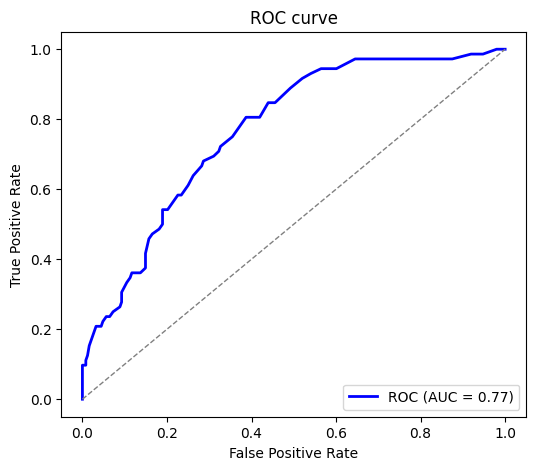

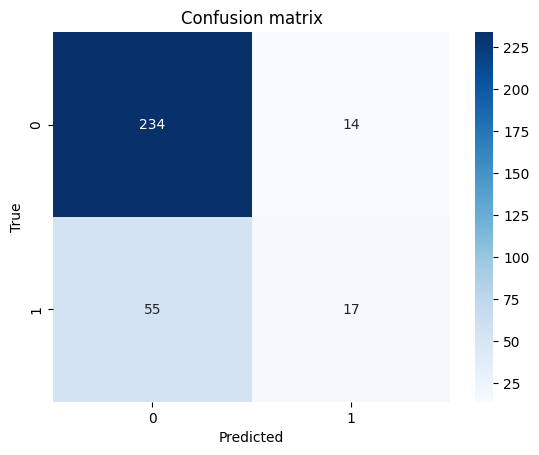

In [9]:
y_pred_probs = np.array([])
y_pred = np.array([])
y_true = np.array([])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

for i, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    num_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='median')),
        ('normalization', MinMaxScaler())
    ])
    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipeline, numerical_cols),
        ('cat', cat_pipeline, categorical_cols)
    ])
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=2))
    ])

    X_train_split, X_test_split = X.iloc[train_idx], X.iloc[test_idx]
    y_train_split, y_test_split = y.iloc[train_idx], y.iloc[test_idx]
    model.fit(X_train_split, y_train_split)
    y_pred_prob_fold = model.predict_proba(X_test_split)[:, 1]
    y_pred_fold = model.predict(X_test_split)
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test_split, y_pred_prob_fold)
    y_pred_probs = np.concatenate([y_pred_probs, y_pred_prob_fold])
    y_pred = np.concatenate([y_pred, y_pred_fold])
    y_true = np.concatenate([y_true, y_test_split])
    print(f"Fold {i}:")
    print(f"ROC AUC score: {roc_auc_score(y_test_split, y_pred_prob_fold)}\n")

print(f"Total scores:")

false_positive_rate, true_positive_rate, _ = roc_curve(y_true, y_pred_probs)

plt.figure(figsize=(6,5))
plt.plot(false_positive_rate, true_positive_rate, color='blue', lw=2, label=f'ROC (AUC = {roc_auc_score(y_true, y_pred_probs):.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

In [10]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=2)

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('normalization', MinMaxScaler())
])
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=2))
])
params = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__bootstrap': [True, False],
    'classifier__criterion': ['gini', 'entropy', 'log_loss']
}
# params optimization
search = GridSearchCV(model, param_grid=params, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
search.fit(X_train, y_train)
print(f"Best parameters: {search.best_params_}")
print(f"Best ROC AUC score: {search.best_score_}")

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV] END classifier__bootstrap=True, classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.3s
[CV] END classifier__bootstrap=True, classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.3s
[CV] END classifier__bootstrap=True, classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   0.3s
[CV] END classifier__bootstrap=True, classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; tot

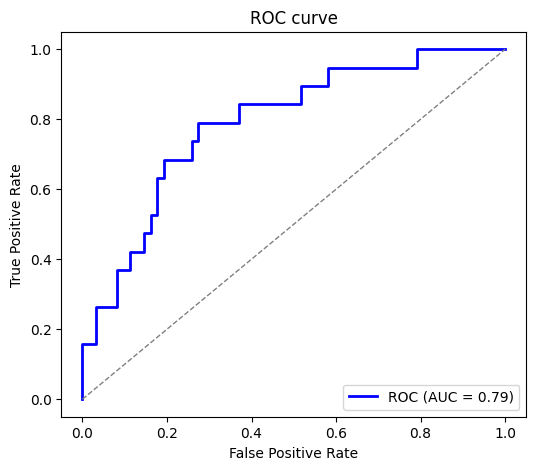

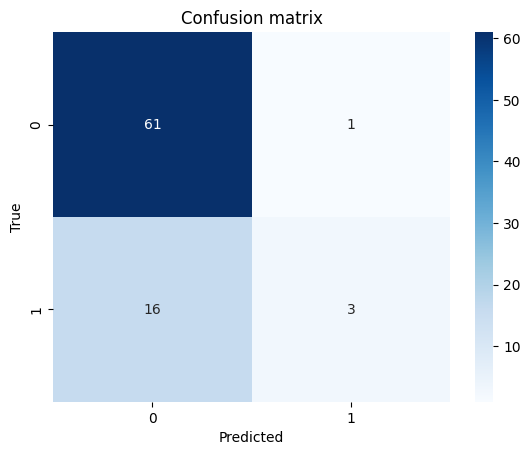

PSAdensity                           0.135880
PSA                                  0.135570
MRI SIZE                             0.102187
MRI vol                              0.092832
wiek                                 0.090307
MRI Pirads_5.0                       0.044346
MRI EPE (naciek poza torebke)_1.0    0.035119
MRI EPE (naciek poza torebke)_0.0    0.024591
MRI Pirads_4.0                       0.022228
Bx ISUP Grade P_5.0                  0.022119
Bx ISUP Grade P_1.0                  0.021797
Bx ISUP Grade_5.0                    0.021734
Bx ISUP Grade_1.0                    0.021024
MRI EPE P_0.0                        0.018826
MRI EPE P_1.0                        0.018371
Bx ISUP Grade L_1.0                  0.016496
MRI Pirads_3.0                       0.015232
Bx ISUP Grade L_0.0                  0.014783
Bx ISUP Grade L_2.0                  0.014161
Bx ISUP Grade P_0.0                  0.012739
Bx ISUP Grade_2.0                    0.012418
Bx ISUP Grade P_2.0               

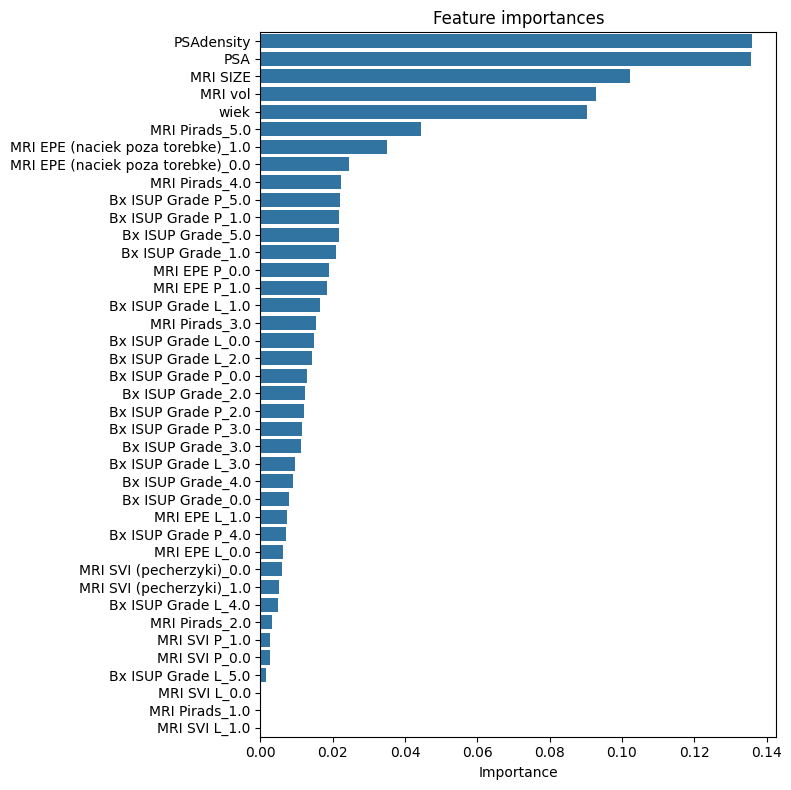

              precision    recall  f1-score   support

         0.0       0.79      0.98      0.88        62
         1.0       0.75      0.16      0.26        19

    accuracy                           0.79        81
   macro avg       0.77      0.57      0.57        81
weighted avg       0.78      0.79      0.73        81



In [11]:
best_params = search.best_params_
best_params = {k.replace('classifier__', ''): v for k, v in best_params.items()}
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(**best_params, random_state=2))
])
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6,5))
plt.plot(false_positive_rate, true_positive_rate, color='blue', lw=2, label=f'ROC (AUC = {roc_auc_score(y_test, y_pred_prob):.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

plot_feature_importances(model, numerical_cols, categorical_cols)

print(classification_report(y_test, y_pred))


# XGBClassifier

In [28]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=2)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=2))
])

param_grid = {
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__n_estimators': [200, 400, 800],
    'classifier__max_depth': [3, 4, 6],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.1, 0.2]
}

search = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
search.fit(X_train, y_train)
print(f"Best parameters: {search.best_params_}")
print(f"Best ROC AUC score: {search.best_score_}")

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=200, classifier__subsample=0.8; total time=   0.2s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=200, classifier__subsample=0.9; total time=   0.1s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=200, classifier__subsample=1.0; total time=   0.1s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=200, classifier__subsample=0.8; total time=   0.1s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=40

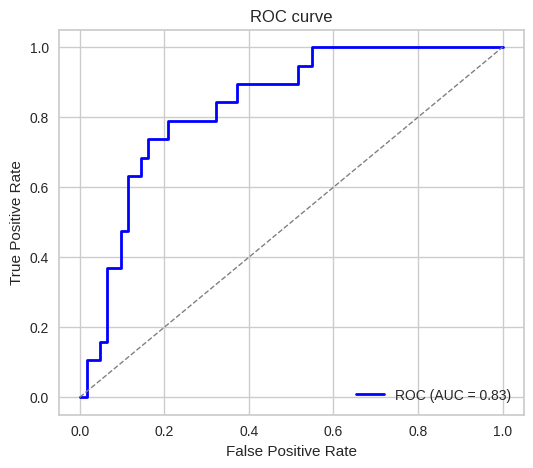

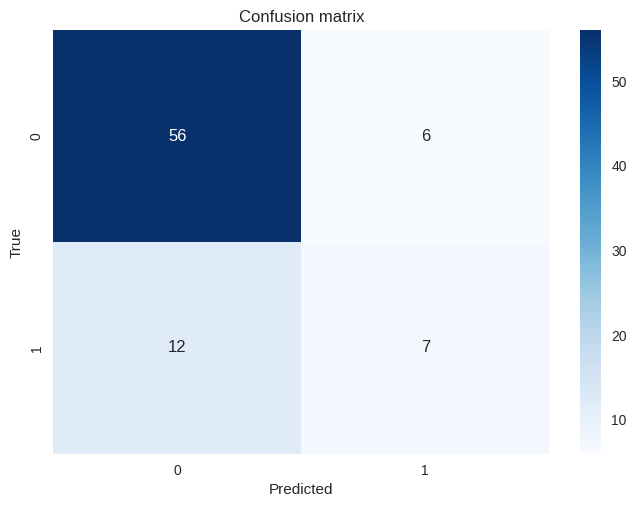

Preparation of a new explainer is initiated



TypeError: 'data' must be pandas.DataFrame or numpy.ndarray

In [31]:
best_params = search.best_params_
best_params = {k.replace('classifier__', ''): v for k, v in best_params.items()}
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(**best_params, random_state=2))
])
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6,5))
plt.plot(false_positive_rate, true_positive_rate, color='blue', lw=2, label=f'ROC (AUC = {roc_auc_score(y_test, y_pred_prob):.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

plot_feature_importances(model, numerical_cols, categorical_cols)

print(classification_report(y_test, y_pred))

# macro EPE results

In [36]:
y = df['EPE macro']

Fold 0:
ROC AUC score: 0.9898305084745763

Fold 1:
ROC AUC score: 0.9913793103448276

Fold 2:
ROC AUC score: 0.987468671679198

Fold 3:
ROC AUC score: 0.959016393442623

Fold 4:
ROC AUC score: 0.9818181818181819

Total scores:


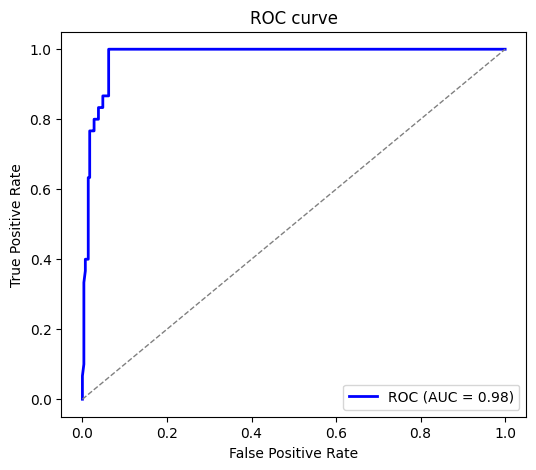

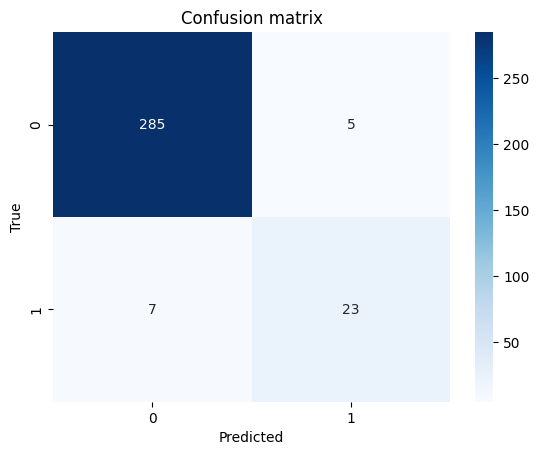

In [37]:
y_pred_probs = np.array([])
y_pred = np.array([])
y_true = np.array([])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

for i, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    num_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='median')),
        ('normalization', MinMaxScaler())
    ])
    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipeline, numerical_cols),
        ('cat', cat_pipeline, categorical_cols)
    ])
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=2))
    ])

    X_train_split, X_test_split = X.iloc[train_idx], X.iloc[test_idx]
    y_train_split, y_test_split = y.iloc[train_idx], y.iloc[test_idx]
    model.fit(X_train_split, y_train_split)
    y_pred_prob_fold = model.predict_proba(X_test_split)[:, 1]
    y_pred_fold = model.predict(X_test_split)
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test_split, y_pred_prob_fold)
    y_pred_probs = np.concatenate([y_pred_probs, y_pred_prob_fold])
    y_pred = np.concatenate([y_pred, y_pred_fold])
    y_true = np.concatenate([y_true, y_test_split])
    print(f"Fold {i}:")
    print(f"ROC AUC score: {roc_auc_score(y_test_split, y_pred_prob_fold)}\n")

print(f"Total scores:")

false_positive_rate, true_positive_rate, _ = roc_curve(y_true, y_pred_probs)

plt.figure(figsize=(6,5))
plt.plot(false_positive_rate, true_positive_rate, color='blue', lw=2, label=f'ROC (AUC = {roc_auc_score(y_true, y_pred_probs):.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

# EPE RP

In [ ]:
y = df['EPE RP']

In [40]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=2)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=2))
])

param_grid = {
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__n_estimators': [200, 400, 800],
    'classifier__max_depth': [3, 4, 6],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.1, 0.2]
}

search = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
search.fit(X_train, y_train)
print(f"Best parameters: {search.best_params_}")
print(f"Best ROC AUC score: {search.best_score_}")

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=200, classifier__subsample=0.9; total time=   0.2s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=200, classifier__subsample=0.9; total time=   0.1s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=200, classifier__subsample=0.9; total time=   0.1s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=200, classifier__subsample=0.8; total time=   0.1s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=200, classifier__subsample=1.0; total time=   0.2s
[CV] END classi

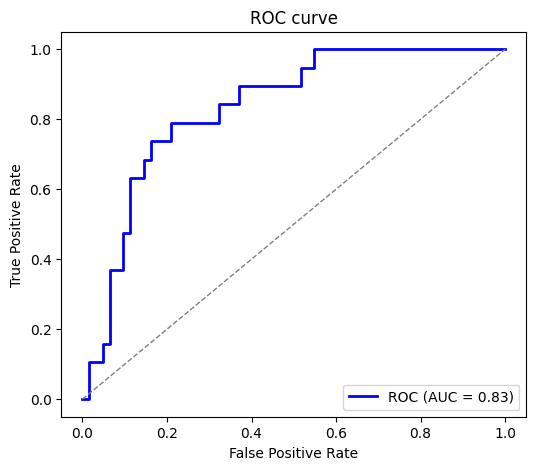

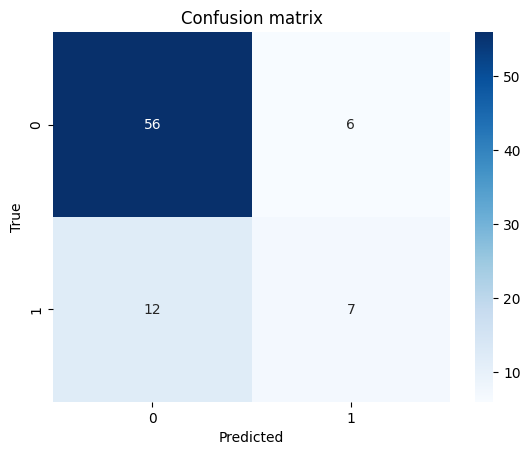

MRI Pirads_5.0                       0.081028
Bx ISUP Grade_5.0                    0.071891
MRI EPE (naciek poza torebke)_0.0    0.070794
Bx ISUP Grade_4.0                    0.055087
Bx ISUP Grade P_5.0                  0.053495
Bx ISUP Grade P_3.0                  0.049924
Bx ISUP Grade P_4.0                  0.049465
Bx ISUP Grade_1.0                    0.043005
PSA                                  0.042026
Bx ISUP Grade L_3.0                  0.040099
MRI Pirads_4.0                       0.038274
PSAdensity                           0.036554
MRI SIZE                             0.034356
wiek                                 0.034078
MRI Pirads_3.0                       0.031174
MRI vol                              0.030977
Bx ISUP Grade_2.0                    0.030391
Bx ISUP Grade L_1.0                  0.029608
Bx ISUP Grade L_2.0                  0.028744
Bx ISUP Grade L_4.0                  0.027919
Bx ISUP Grade P_2.0                  0.027470
Bx ISUP Grade P_1.0               

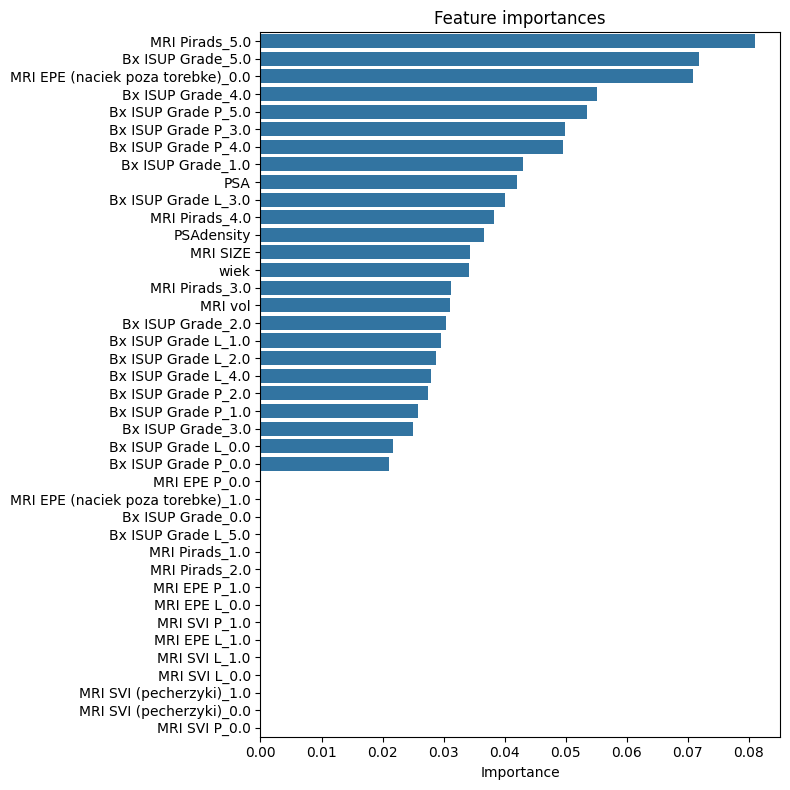

              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86        62
         1.0       0.54      0.37      0.44        19

    accuracy                           0.78        81
   macro avg       0.68      0.64      0.65        81
weighted avg       0.76      0.78      0.76        81



In [ ]:
best_params = search.best_params_
best_params = {k.replace('classifier__', ''): v for k, v in best_params.items()}
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(**best_params, random_state=2))
])
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6,5))
plt.plot(false_positive_rate, true_positive_rate, color='blue', lw=2, label=f'ROC (AUC = {roc_auc_score(y_test, y_pred_prob):.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

plot_feature_importances(model, numerical_cols, categorical_cols)

print(classification_report(y_test, y_pred))

In [23]:
def train_and_evaluate_model(model, X, y, numerical_cols, categorical_cols, n_folds):
    y_pred_probs = np.array([])
    y_pred = np.array([])
    y_true = np.array([])

    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=2)

    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        num_pipeline = Pipeline(steps=[
            ('impute', SimpleImputer(strategy='median')),
            ('normalization', MinMaxScaler())
        ])
        cat_pipeline = Pipeline(steps=[
            ('impute', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
        ])
        preprocessor = ColumnTransformer(transformers=[
            ('num', num_pipeline, numerical_cols),
            ('cat', cat_pipeline, categorical_cols)
        ])
        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        X_train_split, X_test_split = X.iloc[train_idx], X.iloc[test_idx]
        y_train_split, y_test_split = y.iloc[train_idx], y.iloc[test_idx]
        model_pipeline.fit(X_train_split, y_train_split)
        y_pred_prob_fold = model_pipeline.predict_proba(X_test_split)[:, 1]
        y_pred_fold = model_pipeline.predict(X_test_split)
        false_positive_rate, true_positive_rate, _ = roc_curve(y_test_split, y_pred_prob_fold)
        y_pred_probs = np.concatenate([y_pred_probs, y_pred_prob_fold])
        y_pred = np.concatenate([y_pred, y_pred_fold])
        y_true = np.concatenate([y_true, y_test_split])
        print(f"Fold {i}:")
        print(f"ROC AUC score: {roc_auc_score(y_test_split, y_pred_prob_fold)}\n")
    
    num_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='median')),
        ('normalization', MinMaxScaler())
    ])
    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipeline, numerical_cols),
        ('cat', cat_pipeline, categorical_cols)
    ])
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    model_pipeline.fit(X, y)

    print(f"Total scores:")

    false_positive_rate, true_positive_rate, _ = roc_curve(y_true, y_pred_probs)
    total_roc_auc = roc_auc_score(y_true, y_pred_probs)
    print(f"ROC AUC score: {total_roc_auc}\n")
    return y_true, y_pred, y_pred_probs, false_positive_rate, true_positive_rate, total_roc_auc, model_pipeline

def plot_roc(false_positive_rate, true_positive_rate, total_roc_auc):
    plt.figure(figsize=(6,5))
    plt.plot(false_positive_rate, true_positive_rate, color='blue', lw=2, label=f'ROC (AUC = {total_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion matrix')
    plt.show()

def plot_feature_importances(model, X, y):
    explainer = dx.Explainer(model, X, y)
    importances = explainer.model_parts()
    importances.plot()

def plot_discrimination_threshold(model, X, y):
    visualizer = DiscriminationThreshold(model)
    visualizer.fit(X, y)
    visualizer.show()

Fold 0:
ROC AUC score: 0.731748726655348

Fold 1:
ROC AUC score: 0.793010752688172

Fold 2:
ROC AUC score: 0.8270609318996416

Fold 3:
ROC AUC score: 0.732078853046595

Fold 4:
ROC AUC score: 0.6747195858498706

Total scores:
ROC AUC score: 0.7376530181511186



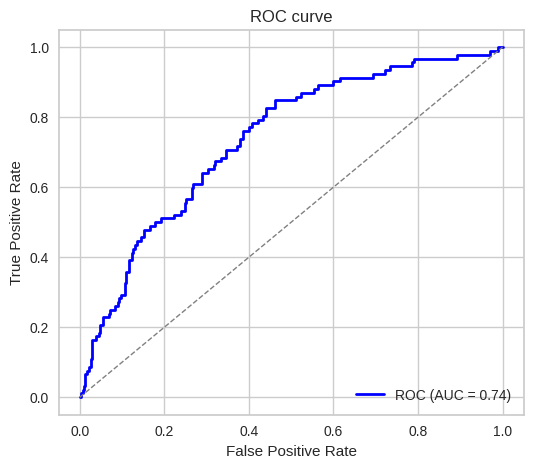

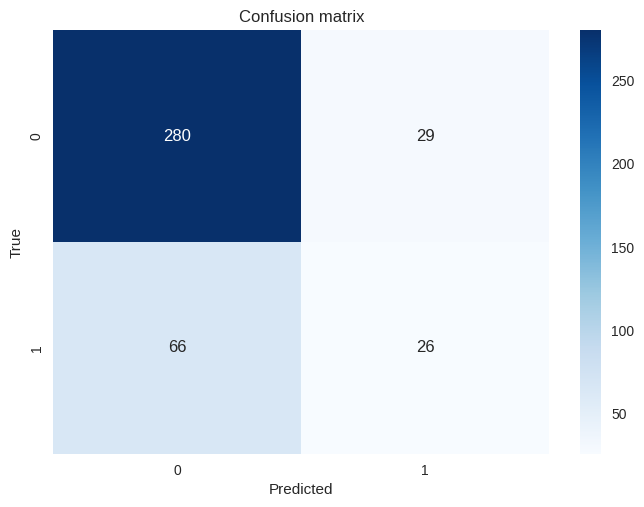

Preparation of a new explainer is initiated

  -> data              : 401 rows 15 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 401 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7f93df8d6f20> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.00306, mean = 0.23, max = 0.904
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.691, mean = -0.00103, max = 0.926
  -> model_info        : package sklearn

A new explainer has been created!


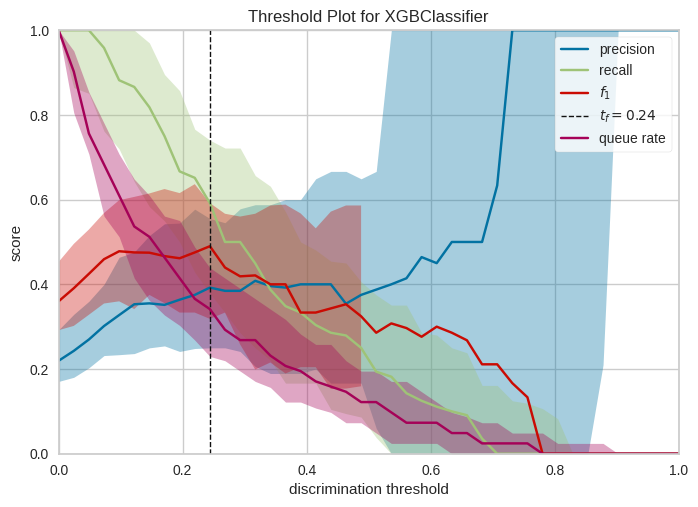

In [24]:
numerical_cols = ['wiek', 'PSA', 'PSAdensity', 'MRI vol', 'MRI SIZE']
categorical_cols = ['MRI EPE (naciek poza torebke)', 'MRI Pirads', 'MRI EPE L', 'MRI EPE P', 'MRI SVI (pecherzyki)', 'MRI SVI L', 'MRI SVI P','Bx ISUP Grade P', 'Bx ISUP Grade L', 'Bx ISUP Grade']

X = df[numerical_cols + categorical_cols]
y = df['EPE micro']
hyperparams = {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

model = XGBClassifier(random_state=2, **hyperparams)

y_true, y_pred, y_pred_probs, false_positive_rate, true_positive_rate, total_roc_auc, trained_model = train_and_evaluate_model(model, X, y, numerical_cols, categorical_cols, n_folds=5)
plot_roc(false_positive_rate, true_positive_rate, total_roc_auc)
plot_confusion_matrix(y_true, y_pred)
plot_feature_importances(trained_model, X, y)
plot_discrimination_threshold(model, X, y)

# Notes
### brier score - alternative to auc